## Importing libraries

In [1]:
import pandas as pd
from dotenv import load_dotenv
import os
import pymysql
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore") 

In [2]:
## load env
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
load_dotenv(os.path.join(BASE_DIR, '.env'))

True

## Retrieve client data

In [3]:
# find newly added and edited transactions
conn = pymysql.connect(host=os.getenv("MYSQL_DB_HOST") ,
                       port=3306,
                       user=os.getenv("MYSQL_DB_USER"),
                       passwd=os.getenv("MYSQL_DB_PASSWORD"),
                       db=os.getenv("MYSQL_DB_NAME"))

transaction data

In [4]:
trxn_df = pd.read_sql_query(("Select profileID,max(transactionDate) as lastTransactionDate,sum(transactionAmount) " 
                             "as monetaryValue, count(*) as frequency from transactions group by profileID"), con=conn)

client status data

In [5]:
client_status_df = pd.read_sql_query(("Select * from clients"), con=conn)

filter for only active clients

In [6]:
client_df = trxn_df.merge(client_status_df[["profileID"]],on="profileID")

In [7]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8785 entries, 0 to 8784
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   profileID            8785 non-null   object        
 1   lastTransactionDate  8785 non-null   datetime64[ns]
 2   monetaryValue        8785 non-null   float64       
 3   frequency            8785 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 274.7+ KB


## Find time between first and last transactions

In [36]:
first_trasaction_df = client_df.lastTransactionDate.min()

In [37]:
recent_transaction_dt = client_df.lastTransactionDate.max()

In [49]:
number_of_days = (recent_transaction_dt - first_trasaction_df).days

This client data analysis analyzes client data generated over 936 days, i.e; about 2 years and 7 months

## Calculate Recency values

In [8]:
# recency
client_df['recency'] = (datetime.now().date() - client_df['lastTransactionDate'].dt.date)

In [9]:
# extract days for recency
client_df.recency = client_df.recency.apply(lambda row:str(row).split("days")[0])
client_df.recency = client_df.recency.apply(lambda row:str(row).split("day")[0])

In [10]:
client_df.recency = client_df.recency.astype(int)

## Plotting RFM distributions

Recency

In [11]:
client_df.recency.max()

944

In [52]:
client_df.recency.min()

8

(array([5330., 3203.,  175.,   62.,   15.]),
 array([  8. , 195.2, 382.4, 569.6, 756.8, 944. ]),
 <BarContainer object of 5 artists>)

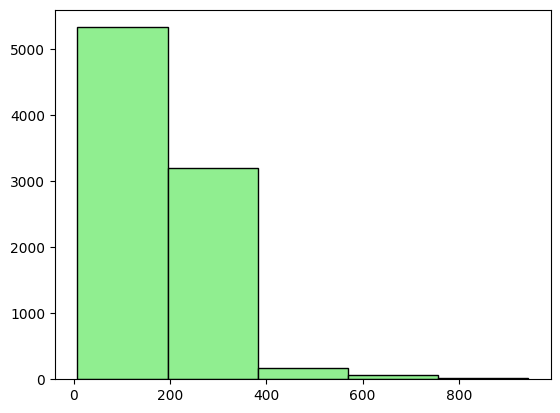

In [55]:
plt.hist(client_df.recency, color='lightgreen', ec='black', bins=5)

This plot shows that more than 5000 of the active client base have transacted in the last 50 days. Which is  over half the client base. With the highest number of days being 944 days and the lowest being 8 days

Frequency

In [14]:
client_df.frequency.max()

6969

In [15]:
client_df.frequency.min()

1

(array([8.66e+03, 1.07e+02, 1.00e+01, 4.00e+00, 3.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([1.0000e+00, 6.9780e+02, 1.3946e+03, 2.0914e+03, 2.7882e+03,
        3.4850e+03, 4.1818e+03, 4.8786e+03, 5.5754e+03, 6.2722e+03,
        6.9690e+03]),
 <BarContainer object of 10 artists>)

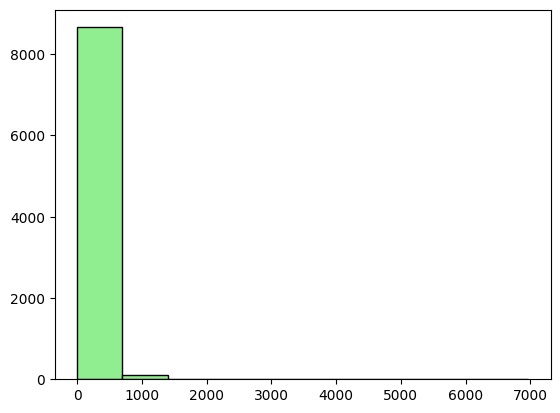

In [57]:
plt.hist(client_df.frequency, color='lightgreen', ec='black', bins=10)

This plot shows that almost all of the active client base have made less than 1000 transactions. With the highest being 6969 and the lowest being 1.

Monetary Value

In [17]:
client_df.monetaryValue.max()

24744051.28

In [18]:
client_df.monetaryValue.min()

0.67

(array([8.778e+03, 4.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([6.70000000e-01, 4.94881079e+06, 9.89762091e+06, 1.48464310e+07,
        1.97952412e+07, 2.47440513e+07]),
 <BarContainer object of 5 artists>)

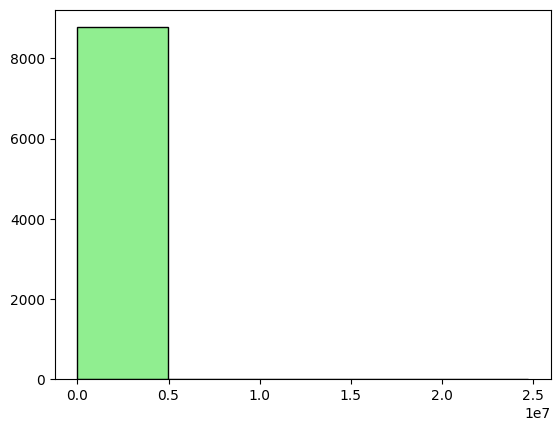

In [62]:
plt.hist(client_df.monetaryValue, color='lightgreen', ec='black', bins=5)

This plot shows that almost all of the active client base have a very low monetary value. With the highest being GHS 24744051.28 and the lowest being 67 pesewas.

## Calculate RFM scores

In [20]:
recency_scores = [5, 4, 3, 2, 1]  # Higher score for lower recency (more recent transactions)
frequency_scores = [1, 2, 3, 4, 5]  # Higher score for higher frequency
monetary_scores = [1, 2, 3, 4, 5]  # Higher score for higher monetary value

# Calculate RFM scores
client_df['recencyScore'] = pd.cut(client_df['recency'], bins=5, labels=recency_scores)
client_df['frequencyScore'] = pd.cut(client_df['frequency'], bins=5, labels=frequency_scores)
client_df['monetaryScore'] = pd.cut(client_df['monetaryValue'], bins=5, labels=monetary_scores)

In [21]:
client_df['recencyScore'] = client_df['recencyScore'].astype(int)
client_df['frequencyScore'] = client_df['frequencyScore'].astype(int)
client_df['monetaryScore'] = client_df['monetaryScore'].astype(int)

The highest RFM score a client can have is 15. When they belong to the highest value in both frequency and monetary value they get a 5. Also if they have transacted very recently they score a 5. All together makes a 15

## RFM value segmentation

In [22]:
# calc RFM score
client_df['rfmScore'] = client_df['recencyScore'] + client_df['frequencyScore'] + client_df['monetaryScore']

find min and max RFM Score

In [68]:
client_df.rfmScore.min()

3

In [67]:
client_df.rfmScore.max()

13

RFM score distribution

(array([7.700e+01, 3.375e+03, 5.325e+03, 6.000e+00, 2.000e+00]),
 array([ 3.,  5.,  7.,  9., 11., 13.]),
 <BarContainer object of 5 artists>)

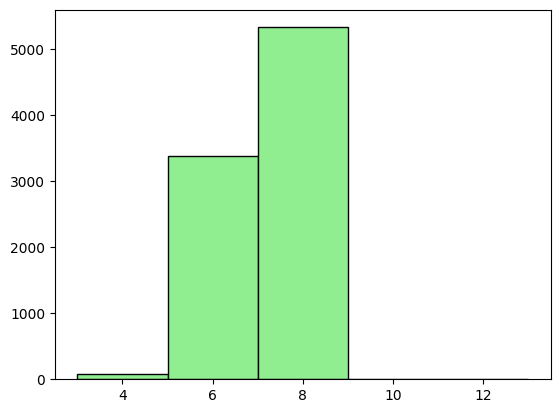

In [69]:
plt.hist(client_df.rfmScore, color='lightgreen', ec='black', bins=5)

From this diagram we can see a little over half of the active client base belong to the midvalue RFM score bin

In [23]:
# Create RFM segments based on the RFM score
segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']
client_df['valueSegment'] = pd.qcut(client_df['rfmScore'], q=3, labels=segment_labels)

Segment distribution

In [24]:
segment_counts = client_df['valueSegment'].value_counts().reset_index()

In [25]:
segment_counts

,valueSegment,count
0,Mid-Value,5313
1,Low-Value,3452
2,High-Value,20


bar chart

In [26]:
fig = plt.figure(figsize = (10, 5))

<Figure size 1000x500 with 0 Axes>

In [27]:
segments = list(segment_counts["valueSegment"].unique())
segment_values = list(segment_counts["count"].unique())

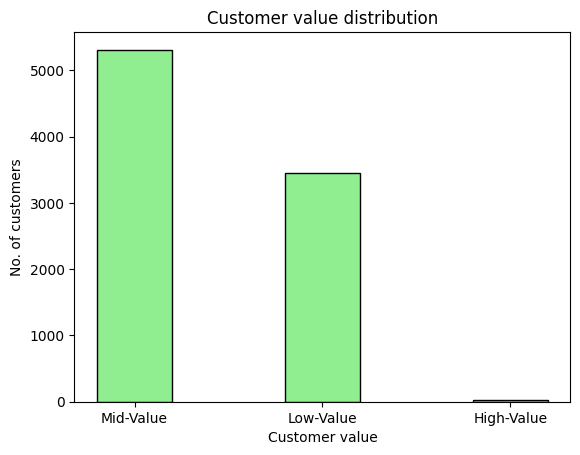

In [82]:
plt.bar(segments, segment_values, color ='lightgreen',ec='black',
        width = 0.4)
plt.xlabel("Customer value")
plt.ylabel("No. of customers")
plt.title("Customer value distribution")
plt.show()

## RFM Customer Segmentation

In [29]:
# Assign RFM segments based on the RFM score
client_df.loc[client_df['rfmScore'] >= 9, 'RFMCustomerSegments'] = 'Champions'
client_df.loc[(client_df['rfmScore'] >= 6) & (client_df['rfmScore'] < 9), 'RFMCustomerSegments'] = 'Potential Loyalists'
client_df.loc[(client_df['rfmScore'] >= 5) & (client_df['rfmScore'] < 6), 'RFMCustomerSegments'] = 'Promising'
client_df.loc[(client_df['rfmScore'] >= 4) & (client_df['rfmScore'] < 5), 'RFMCustomerSegments'] = "Needs Attention"
client_df.loc[(client_df['rfmScore'] >= 3) & (client_df['rfmScore'] < 4), 'RFMCustomerSegments'] = "Lost"

value and customer segment distribution

In [30]:
segment_product_counts = client_df.groupby(['valueSegment', 'RFMCustomerSegments']).size().reset_index(name='Count')

In [31]:
segment_product_counts = segment_product_counts.sort_values('Count', ascending=False)

In [74]:
segment_product_counts = segment_product_counts[segment_product_counts["Count"]>0]

Plot Customer Segments distribution

In [83]:
segment_product_counts

,valueSegment,RFMCustomerSegments,Count
8,Mid-Value,Potential Loyalists,5313
3,Low-Value,Potential Loyalists,3201
4,Low-Value,Promising,174
2,Low-Value,Needs Attention,62
1,Low-Value,Lost,15
13,High-Value,Potential Loyalists,12
10,High-Value,Champions,8


(array([3., 0., 1., 0., 0., 1., 0., 1., 0., 1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

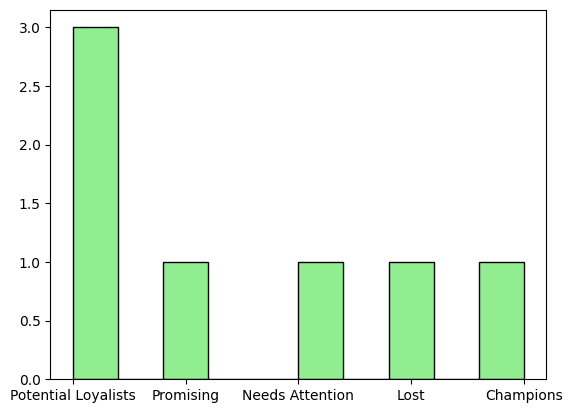

In [85]:
plt.hist(segment_product_counts.RFMCustomerSegments, color='lightgreen', ec='black')

In [33]:
# 20 september 2023